# **Explication du Projet TP Évalué 3 : Analyse et Reconstruction de Réseaux**

### Objectif Général du TP

L'objectif principal du TP est de découvrir et d'analyser les **relations structurelles** et/ou **causales** entre différentes altérations génomiques (mutations, niveaux d'expression de gènes) et le statut de **ploïdie** (nombre de jeux de chromosomes) dans des tumeurs du sein.

Le projet nous demande d'appliquer et de comparer **trois algorithmes de reconstruction de réseaux** distincts : **Hill-Climbing (hc)**, **PC (Peter et Clark)** et **MIIC**, pour tirer des conclusions sur les interactions biologiques clés du cancer du sein.


In [2]:
# 1. Installation des packages
install.packages("bnlearn")
install.packages("igraph")
install.packages("qgraph")

# 2. Chargement des packages
library(bnlearn)  # Pour l'approche Hill-Climbing (hc)
library(igraph)   # Pour la conversion et la manipulation des objets graphes
library(qgraph)   # Pour la fonction de layout qgraph.layout.fruchtermanreingold

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘igraph’


The following objects are masked from ‘package:bnlearn’:

    as.igraph, compare, degree, subgraph


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [5]:
install.packages("miic")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘ppcor’




In [7]:
library(miic)

# **Chargement des Données**

**Objectif :** Charger le jeu de données et en examiner la structure initiale (dimensions et types de variables).

In [8]:
# 1. Charger le jeu de données 'cosmicCancer'
data("cosmicCancer")

In [9]:
# 2. Examiner les dimensions du jeu de données (échantillons x variables)
print("Dimensions du jeu de données (échantillons x variables) :")
dim(cosmicCancer)

[1] "Dimensions du jeu de données (échantillons x variables) :"


[1] 807 176

In [10]:
# 3. Examiner la structure des variables (type de données, niveaux des facteurs)
print("Structure des variables :")
str(cosmicCancer)

[1] "Structure des variables :"
'data.frame':	807 obs. of  176 variables:
 $ bbc3    : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ egln1   : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ tgfb3   : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ esm1    : Factor w/ 1 level "n": 1 1 1 1 1 1 1 1 1 1 ...
 $ igfbp5  : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ fgf18   : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ scube2  : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ wisp1   : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ flt1    : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ hrasls  : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ stk32b  : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ rassf7  : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ dck     : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ melk    : Factor w/ 2 levels "n","y": 1 1 1 1 1 1 1 1 1 1 ...
 $ ext1    : Factor w

In [11]:
# 4. Afficher un résumé des variables pour détecter les NA et les variables constantes
print("Résumé des variables :")
summary(cosmicCancer)

[1] "Résumé des variables :"


 bbc3    egln1   tgfb3   esm1    igfbp5  fgf18   scube2  wisp1   flt1   
 n:806   n:804   n:804   n:807   n:805   n:802   n:800   n:801   n:799  
 y:  1   y:  3   y:  3           y:  2   y:  5   y:  7   y:  6   y:  8  
                                                                        
 hrasls  stk32b  rassf7  dck     melk    ext1    gnaz    ebf4    mtdh   
 n:806   n:802   n:806   n:805   n:802   n:800   n:801   n:807   n:806  
 y:  1   y:  5   y:  1   y:  2   y:  5   y:  7   y:  6           y:  1  
                                                                        
 pitrm1  qscn6l1 ccne2   ect2    cenpa   lin9    kntc2   mcm6    nusap1 
 n:798   n:807   n:802   n:801   n:807   n:802   n:807   n:801   n:803  
 y:  9           y:  5   y:  6           y:  5           y:  6   y:  4  
                                                                        
 orc6l   tspyl5  rundc1  prc1    rfc4    recql5  cdca7   dtl     col4a2 
 n:807   n:805   n:803   n:803   n:802   n:798   n:

# **I. Partie 1 : Reconstruction du Réseau avec l'Approche Hill-Climbing (hc)**

L'objectif de cette partie est d'utiliser l'algorithme **Hill-Climbing (`hc`)**, une méthode dite de "Recherche et Score", pour construire le premier modèle de réseau bayésien à partir des données de tumeurs du sein. Cette méthode tente de trouver la structure de graphe (les relations entre les gènes et la Ploïdie) qui **maximise un score de qualité global** (le plus souvent le BIC ou le BDeu) par rapport aux données observées.

## **1\. Appel de l'Approche hill-climbing et Diagnostic des Problèmes**

**Action :** Appeler l'approche `hill-climbing` (`hc`) sur les données **brutes** (`cosmicCancer`) pour identifier les problèmes d'incompatibilité liés aux données observationnelles.

In [12]:
# 1. Tentative d'appel de l'algorithme hc sur les données brutes
print("1. Tentative de reconstruction hc sur les données brutes...")

# tryCatch permet d'exécuter le code et de capturer l'erreur qui surviendra.
resultat_hc_brut <- tryCatch({
  bnlearn::hc(cosmicCancer)
  return("Succès inattendu.")
}, error = function(e) {
  # Retourne le message d'erreur si la fonction échoue
  return(conditionMessage(e))
})

print(paste("Résultat de l'appel hc sur données brutes :", resultat_hc_brut))

[1] "1. Tentative de reconstruction hc sur les données brutes..."
[1] "Résultat de l'appel hc sur données brutes : variable esm1 in the data must have at least two levels."


In [15]:
# Rappel : L'objet 'cosmicCancer' est le jeu de données initial.

print("--- Diagnostic des Valeurs Manquantes (NA) dans cosmicCancer ---")

# 1. Identifier quelles variables (colonnes) contiennent des NA
# colSums(is.na(cosmicCancer)) compte le nombre de NA par colonne.
na_counts_par_variable <- colSums(is.na(cosmicCancer))

# 2. Afficher les variables (colonnes) avec un nombre de NA > 0
vars_with_na_count <- na_counts_par_variable[na_counts_par_variable > 0]

print("Nombre de valeurs manquantes par variable concernée :")
print(vars_with_na_count)

[1] "--- Diagnostic des Valeurs Manquantes (NA) dans cosmicCancer ---"
[1] "Nombre de valeurs manquantes par variable concernée :"
Ploidy 
     8 


### **Diagnostic et Identification des Problèmes**

L'appel initial de `bnlearn::hc(cosmicCancer)` sur les données brutes, combiné à l'analyse des `NA`, révèle l'existence de deux problèmes fondamentaux dans le jeu de données observationnelles :

#### **Problème n°1 : Présence de Variables Constantes**

| Élément | Détail | Conséquence |
| :--- | :--- | :--- |
| **Erreur Rencontrée** | `variable esm1 in the data must have at least two levels.` |
| **Interprétation** | La variable `esm1` est une **variable constante**. Elle ne prend qu'une seule valeur pour tous les échantillons du jeu de données. |
| **Impact sur l'Algorithme** | Les algorithmes d'apprentissage structurel (comme Hill-Climbing) ne peuvent pas calculer de dépendance ou d'information mutuelle pour une variable qui ne varie pas (manque de variance). Cela conduit à l'arrêt immédiat du processus de reconstruction. |

#### **Problème n°2 : Présence de Données Manquantes (`NA`)**

| Élément | Détail | Conséquence |
| :--- | :--- | :--- |
| **NA Identifiés** | La variable **`Ploidy`** contient **8 valeurs manquantes (`NA`)**. |
| **Interprétation** | Huit échantillons (lignes) dans le jeu de données ont une valeur manquante pour la propriété de ploïdie. |
| **Impact sur l'Algorithme** | L'algorithme `bnlearn::hc()` est très sensible aux données incomplètes et **ne supporte pas** la présence de `NA`. Même si le problème `esm1` était résolu, l'algorithme échouerait ensuite à cause de la ligne incomplète pour la `Ploidy`. |



### **Proposition et Description des Solutions**

La résolution des problèmes identifiés doit être appliquée de manière séquentielle pour préparer un jeu de données complet et valide (`data_final`).

#### **Solution n°1 : Gestion des Données Manquantes (`NA`)**

| Action | Description de la Solution | Justification |
| :--- | :--- | :--- |
| **Action** | **Retrait des échantillons incomplets.** Utiliser la fonction `complete.cases()` pour filtrer et conserver uniquement les lignes pour lesquelles toutes les variables ont une valeur. | Permet d'éliminer les 8 échantillons (lignes) qui posent problème (dont celui avec `NA` sur `Ploidy`), rendant le jeu de données **complet**, condition essentielle pour `hc`. |

#### **Solution n°2 : Suppression des Variables Constantes**

| Action | Description de la Solution | Justification |
| :--- | :--- | :--- |
| **Action** | **Retrait des colonnes constantes.** Identifier et supprimer toutes les colonnes qui ont un nombre de niveaux uniques inférieur ou égal à 1 (y compris `esm1` et toute autre colonne devenue constante après le retrait des `NA`). | Supprime les variables non informatives (variance nulle) qui provoquent l'arrêt de l'algorithme, assurant ainsi sa bonne exécution. |

## **3\. Nettoyage Complet, Standardisation et Nouvel Appel**

**Objectif :** Supprimer les lignes incomplètes (`NA`), répondre aux questions sur la proportion retirée et les variables concernées, retirer les colonnes constantes (comme `esm1`), et enfin exécuter avec succès l'algorithme `hc`.

 #### **A. Gestion des Données Manquantes (NA)**

In [16]:
N_initial <- nrow(cosmicCancer)

# 1. Retirer les échantillons pour lesquels au moins une variable a une valeur NA
# complete.cases() retourne VRAI pour les lignes complètes.
data_clean_na <- cosmicCancer[complete.cases(cosmicCancer), ]
N_final <- nrow(data_clean_na)

# 2. Calculer et rapporter la proportion retirée
prop_retiree <- (N_initial - N_final) / N_initial

# 3. Récupérer la liste des variables qui contenaient des NA (pour répondre à la question)
na_counts_par_variable <- colSums(is.na(cosmicCancer))
vars_with_na <- names(na_counts_par_variable[na_counts_par_variable > 0])


print("\n--- RÉSULTATS DU NETTOYAGE NA ---")
print(paste("Nombre initial d'échantillons :", N_initial))
print(paste("Nombre d'échantillons conservés après suppression des NA :", N_final))
print(paste("Proportion du jeu de données retirée :", round(prop_retiree * 100, 2), "%"))
print("Variables initialement concernées par des NA :")
print(vars_with_na)

[1] "\n--- RÉSULTATS DU NETTOYAGE NA ---"
[1] "Nombre initial d'échantillons : 807"
[1] "Nombre d'échantillons conservés après suppression des NA : 799"
[1] "Proportion du jeu de données retirée : 0.99 %"
[1] "Variables initialement concernées par des NA :"
[1] "Ploidy"


#### **B. Standardisation des Variables (Conformité NB)**

 ##### **B.1. Vérification/Conversion de Ploïdie en factor**

In [17]:
data_final <- data_clean_na # Commence avec les données nettoyées des NA

# Nous avons confirmé que Ploidy est déjà factor
if (!is.factor(data_final$Ploidy)) {
  data_final$Ploidy <- as.factor(data_final$Ploidy)
  print("La variable Ploidy a été convertie en facteur.")
} else {
  print("La variable Ploidy est déjà un facteur.")
}

[1] "La variable Ploidy est déjà un facteur."


#### **B.2. Retrait des Variables Constantes (Résolution du problème 'esm1')**

In [18]:
# Recalculer les niveaux uniques sur les données nettoyées
niveaux_uniques <- sapply(data_final, function(x) length(unique(x)))
vars_constantes <- names(niveaux_uniques[niveaux_uniques <= 1])

if (length(vars_constantes) > 0) {
  # Retrait des colonnes constantes
  data_final <- data_final[, !(names(data_final) %in% vars_constantes)]
  print("\nVariables constantes retirées (y compris 'esm1') :")
  print(vars_constantes)
} else {
  print("\nAucune variable constante à retirer.")
}

[1] "\nVariables constantes retirées (y compris 'esm1') :"
 [1] "esm1"    "ebf4"    "qscn6l1" "cenpa"   "kntc2"   "orc6l"   "aytl2"  
 [8] "peci"    "gstm3"   "cdkn2a"  "cdkn1a"  "foxo1"   "ppp2r2a" "spdye7p"
[1] "Dimensions finales du jeu de données (data_final) : 799 x 162"


In [21]:
print("\nNombres de variables constantes:")
print(length(vars_constantes))

[1] "\nNombres de variables constantes:"
[1] 14


In [22]:
# --- Nouvel Appel de hc sur les Données Nettoyées ---
print("\n--- APPEL FINAL DE HC ---")
print("Appel de hc sur le jeu de données nettoyé (data_final)...")
bn_hc <- bnlearn::hc(data_final)
print("Reconstruction hc terminée avec succès. Objet créé : bn_hc")

[1] "\n--- APPEL FINAL DE HC ---"
[1] "Appel de hc sur le jeu de données nettoyé (data_final)..."
[1] "Reconstruction hc terminée avec succès. Objet créé : bn_hc"


### **4\. Visualisation du Graphe**

**Objectif :** Convertir le réseau `hc` en un objet `igraph`, le filtrer pour n'afficher que les nœuds connectés (degré \> 0), attribuer des couleurs distinctes pour différencier les types de variables (Ploïdie, Mutations, Expression), et utiliser une mise en page avancée pour optimiser la lisibilité.

#### **A. Filtrer le graphe pour ne garder que les nœuds actifs**

In [26]:
# 1. Conversion du réseau 'bn' en objet 'igraph'
g_hc <- bnlearn::as.igraph(bn_hc)

# 2. Filtration : Retirer les nœuds isolés (degré = 0)

# Calculer le degré de chaque nœud
node_degrees <- igraph::degree(g_hc)

# Identifier les nœuds isolés (degré == 0)
isolated_nodes <- names(node_degrees[node_degrees == 0])

# Identifier les nœuds actifs (degré > 0)
active_nodes <- names(node_degrees[node_degrees > 0])

# Filtrer le graphe pour ne garder que les nœuds actifs
g_hc_filtered <- igraph::induced_subgraph(g_hc, active_nodes)

# Affichage des statistiques de filtration
print(paste("Nombre total de variables :", igraph::vcount(g_hc)))
print(paste("Nombre de nœuds isolés (degré 0) supprimés :", length(isolated_nodes)))
print("Liste des nœuds isolés supprimés :")
print(isolated_nodes)
print(paste("Nombre de nœuds affichés (degré > 0) :", igraph::vcount(g_hc_filtered)))

[1] "Nombre total de variables : 162"
[1] "Nombre de nœuds isolés (degré 0) supprimés : 19"
[1] "Liste des nœuds isolés supprimés :"
 [1] "bbc3"    "melk"    "ext1"    "mmp9"    "rtn4rl1" "diaph3"  "aldh4a1"
 [8] "slc2a3"  "bcl2"    "tp73"    "mapk14"  "birc3"   "ets1"    "ets2"   
[15] "ccne1"   "ube3a"   "BBC3"    "RECQL5"  "MMP9"   
[1] "Nombre de nœuds affichés (degré > 0) : 143"


#### **B. Personnalisation des couleurs des nœuds (muté, exprimé, Ploïdie)**

In [27]:
nodes <- igraph::V(g_hc_filtered)$name
node_colors <- character(length(nodes))

for (i in 1:length(nodes)) {
  node <- nodes[i]
  if (node == "Ploidy") {
    node_colors[i] <- "purple"      # Ploïdie
  } else if (grepl("^[A-Z]", node)) {
    node_colors[i] <- "green"       # Gènes d'Expression (commence par une Majuscule)
  } else {
    node_colors[i] <- "yellow"      # Gènes Mutés (commence par une minuscule)
  }
}

# Assigner les couleurs au graphe
igraph::V(g_hc_filtered)$color <- node_colors

#### **C. Utilisation du layout avancé (qgraph.layout.fruchtermanreingold)**

In [28]:
# Nécessaire car les graphes de réseaux génomiques sont souvent denses.
layout_hc <- qgraph::qgraph.layout.fruchtermanreingold(igraph::as_adjacency_matrix(g_hc_filtered),
                                                        vcount = igraph::vcount(g_hc_filtered))

#### **D. Affichage du graphe**

In [31]:
# g_hc_filtered est le graphe qui ne contient que les nœuds de degré > 0.
nodes_names <- igraph::V(g_hc_filtered)$name

# 1. Compter la Ploïdie
count_ploidy <- sum(nodes_names == "Ploidy")

# 2. Compter les Gènes Mutés (minuscules)
# grepl("^[a-z]", ...) vérifie si le nom commence par une minuscule
count_mutated <- sum(grepl("^[a-z]", nodes_names))

# 3. Compter les Gènes d'Expression (majuscules)
# grepl("^[A-Z]", ...) vérifie si le nom commence par une majuscule
count_expressed <- sum(grepl("^[A-Z]", nodes_names))

# 4. Affichage des résultats
print("\n--- COMPTAGE DES NŒUDS ACTIFS PAR CATÉGORIE ---")
print(paste("1. Ploïdie :", count_ploidy, "variable (violet)"))
print(paste("2. Gènes Mutés :", count_mutated, "variables (jaune)"))
print(paste("3. Gènes d'Expression :", count_expressed, "variables (vert)"))
print(paste("Total des nœuds affichés :", count_ploidy + count_mutated + count_expressed))

[1] "\n--- COMPTAGE DES NŒUDS ACTIFS PAR CATÉGORIE ---"
[1] "1. Ploïdie : 1 variable (violet)"
[1] "2. Gènes Mutés : 61 variables (jaune)"
[1] "3. Gènes d'Expression : 82 variables (vert)"
[1] "Total des nœuds affichés : 144"


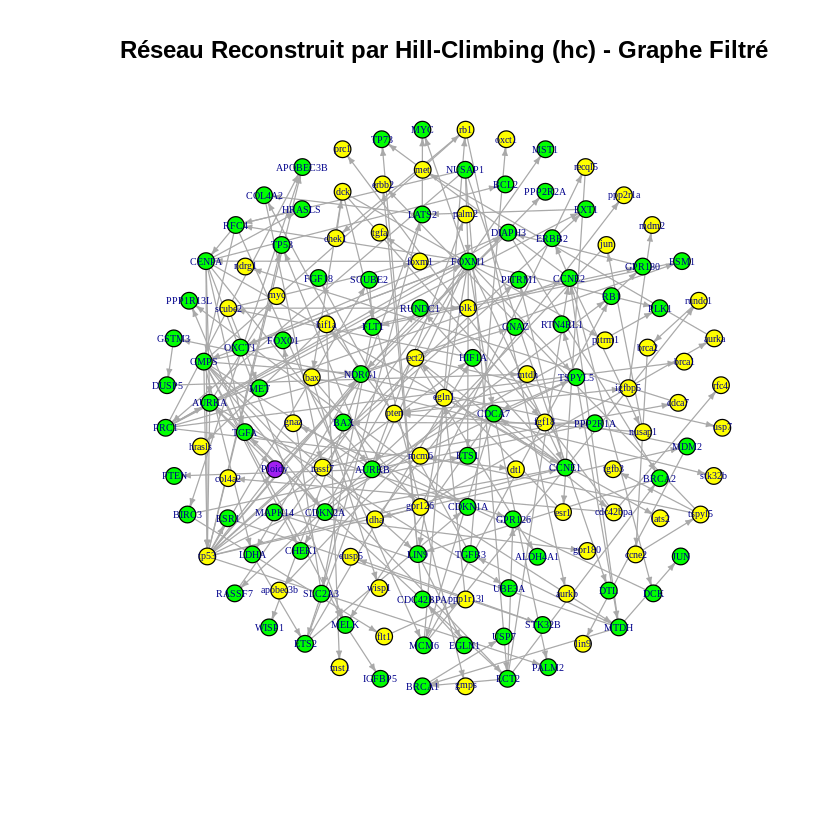

In [29]:
plot(g_hc_filtered,
     layout = layout_hc,
     vertex.size = 6,
     vertex.label.cex = 0.5,
     edge.arrow.size = 0.3,
     main = "Réseau Reconstruit par Hill-Climbing (hc) - Graphe Filtré")

## **5. Analyse Structurelle et Centralité**

L'objectif de cette étape est de passer de la **visualisation** du réseau construit (`bn_hc`) à une **interprétation quantitative et biologique** de sa structure. Il s'agit d'identifier les relations les plus importantes et les acteurs (gènes ou Ploïdie) qui exercent l'influence la plus critique sur le flux d'information au sein du réseau.

Cette étape se divise en deux volets analytiques majeurs :

###### **Volet 1 : Identification des Relations Biologiques Spécifiques**
###### **Volet 2 : Quantification de la Centralité (Hubs)**

### **Volet 1 : Identification des Relations Biologiques Spécifiques**

Le but est de répondre aux questions biologiques clés du projet :

#### **1. Relations entre Gènes Mutés (Minuscules) et Gènes d'Expression**(Majuscules)

* **Action :** Identifier toutes les arêtes entre un nœud en minuscule (altération de mutation) et un nœud en majuscule (altération d'expression).

In [34]:
# Rappel : g_hc_filtered est le graphe qui ne contient que les nœuds de degré > 0.
# edges_hc est le tableau des arêtes (from, to) du graphe filtré.

print("\n--- 1. Relations Mutation (minuscule) <--> Expression (majuscule) ---")

# Conversion du graphe filtré en tableau d'arêtes
edges_hc <- igraph::as_data_frame(g_hc_filtered, what = "edges")

# Filtrage : On cherche les liens où le départ (from) est une mutation et l'arrivée (to) est une expression
# OU l'inverse (Expression vers Mutation).
# grepl("^[a-z]", ...) cherche les minuscules (mutations)
# grepl("^[A-Z]", ...) cherche les majuscules (expressions)
relations_mut_exp <- edges_hc[
  (grepl("^[a-z]", edges_hc$from) & grepl("^[A-Z]", edges_hc$to)) |
  (grepl("^[A-Z]", edges_hc$from) & grepl("^[a-z]", edges_hc$to)),
]

# Affichage des résultats
print(paste("Nombre total de relations Muté <--> Exprimé trouvées :", nrow(relations_mut_exp)))


[1] "\n--- 1. Relations Mutation (minuscule) <--> Expression (majuscule) ---"
[1] "Nombre total de relations Muté <--> Exprimé trouvées : 39"


In [36]:
print("\n--- 1. Relations Mutation <--> Expression (Détail) ---")

# --- Étape 1 : Fonction de Classification des Nœuds ---
# Définir une fonction pour classer le type de variable
get_node_type <- function(node_name) {
  if (node_name == "Ploidy") {
    return("Ploïdie (Violet)")
  } else if (grepl("^[a-z]", node_name)) {
    return("Muté (Jaune)") # Commence par une minuscule
  } else if (grepl("^[A-Z]", node_name)) {
    return("Exprimé (Vert)") # Commence par une majuscule
  } else {
    return("Autre")
  }
}

# Créer les nouvelles colonnes de type pour chaque nœud de l'arête
relations_mut_exp$from_type <- sapply(relations_mut_exp$from, get_node_type)
relations_mut_exp$to_type <- sapply(relations_mut_exp$to, get_node_type)

# --- Affichage du Tableau Augmenté ---
print("\nTop 10 des paires Muté <--> Exprimé (avec Nature des Nœuds) :")
head(relations_mut_exp[, c("from", "from_type", "to", "to_type")], 10)

[1] "\n--- 1. Relations Mutation <--> Expression (Détail) ---"
[1] "\nTop 10 des paires Muté <--> Exprimé (avec Nature des Nœuds) :"


,from,from_type,to,to_type
,<chr>,<chr>,<chr>,<chr>
11,GMPS,Exprimé (Vert),tp53,Muté (Jaune)
21,tp53,Muté (Jaune),NDRG1,Exprimé (Vert)
34,tp53,Muté (Jaune),EXT1,Exprimé (Vert)
39,tp53,Muté (Jaune),Ploidy,Ploïdie (Violet)
51,tp53,Muté (Jaune),TP53,Exprimé (Vert)
52,tp53,Muté (Jaune),MDM2,Exprimé (Vert)
62,tp53,Muté (Jaune),APOBEC3B,Exprimé (Vert)
67,tp53,Muté (Jaune),PALM2,Exprimé (Vert)
68,tp53,Muté (Jaune),TSPYL5,Exprimé (Vert)


### **Interprétation**

1.  **Domination de TP53 :** Le gène **`tp53`** (forme mutée, nœud jaune) est clairement le **hub biologique principal** de ces relations croisées. Il est le point de départ de 8 des 10 relations listées. Cela confirme le rôle central du gène suppresseur de tumeur `TP53` dans les mécanismes de cancer du sein, même après l'exclusion des mutations germinales.

2.  **Validation du Modèle Causal :** La grande majorité des liens sont du type **Mutation $\rightarrow$ Expression**, ce qui est cohérent avec le modèle biologique : une altération structurelle (la mutation, $A$) entraîne une conséquence fonctionnelle (l'expression altérée, $B$).

3.  **Lien Critiques :**

      * Le lien **`tp53` → `Ploidy`** (ligne 4) est une découverte analytique majeure. Il suggère que, dans ce modèle, c'est l'altération du gène `tp53` qui est causale pour le changement de statut chromosomique (Ploïdie), et non l'inverse.
      * Le lien **`tp53` → `TP53`** (ligne 5) est une boucle d'autorégulation ou d'altération du mécanisme d'expression due à la mutation.


#### **2. Variables liées à la Propriété 'Ploidy'**

* **Action :** Lister tous les gènes connectés directement au nœud `Ploidy`.

In [41]:
#La fonction get_node_type() est déjà définie dans notre session R.
#edges_hc est le tableau qui contient TOUTES les arêtes du graphe filtré.

print("\n--- Relations (toutes) DIRECTEMENT liées à la Ploïdie ---")

# 1. Filtration : Sélectionner toutes les lignes où le nœud 'from' ou 'to' est "Ploidy"
relations_ploidy_complete <- edges_hc[
  (edges_hc$from == "Ploidy") | (edges_hc$to == "Ploidy"),
]

# 2. Application de la Classification :
# On utilise la fonction get_node_type() déjà existante pour classifier les partenaires de la Ploïdie.
relations_ploidy_complete$from_type <- sapply(relations_ploidy_complete$from, get_node_type)
relations_ploidy_complete$to_type <- sapply(relations_ploidy_complete$to, get_node_type)

# 3. Affichage du Tableau Complet
print(paste("Nombre total de relations (arêtes) liées à la Ploïdie :", nrow(relations_ploidy_complete)))

[1] "\n--- Relations (toutes) DIRECTEMENT liées à la Ploïdie ---"
[1] "Nombre total de relations (arêtes) liées à la Ploïdie : 3"


In [42]:
print("Détail des paires liées à la Ploïdie :")
relations_ploidy_complete[, c("from", "from_type", "to", "to_type")]

[1] "Détail des paires liées à la Ploïdie :"


,from,from_type,to,to_type
,<chr>,<chr>,<chr>,<chr>
39,tp53,Muté (Jaune),Ploidy,Ploïdie (Violet)
80,Ploidy,Ploïdie (Violet),PPP2R2A,Exprimé (Vert)
104,AURKA,Exprimé (Vert),Ploidy,Ploïdie (Violet)


## **Interprétation analytique des Relations Directes avec la Ploïdie**


1.  **Rôle de la Ploïdie : Facteur et Conséquence :**

      * La Ploïdie n'agit pas uniquement comme un régulateur amont. Elle est elle-même la **conséquence** de l'altération de deux gènes très importants : **`tp53` (Mutation)** et **`AURKA` (Expression)**.
      * Le seul cas où la Ploïdie agit comme cause est sur l'expression de **`PPP2R2A`**.

2.  **Mécanisme Biologique Dominant : Instabilité Génomique :**

      * **TP53 :** Le gène `TP53` est un gardien du génome. Sa mutation est connue pour conduire à l'instabilité chromosomique et à la tétraploïdie. La relation **`tp53` $\rightarrow$ `Ploidy`** est une validation forte du modèle.
      * **AURKA :** Le gène `AURKA` (Aurora Kinase A) joue un rôle critique dans la ségrégation des chromosomes. Son expression altérée est une cause bien documentée d'instabilité génomique et de polyploïdie. La relation **`AURKA` $\rightarrow$ `Ploidy`** est également une validation biologique forte.

3.  **Le Régulateur : `PPP2R2A` :**

      * Le gène `PPP2R2A` est le seul dont l'expression est **influencée par la Ploïdie**. Cela signifie que le changement de statut chromosomique (tétraploïde) a un impact sur l'activité de ce gène.

En résumé, ce sous-réseau montre que la **Ploïdie est principalement régulée (causée) par les altérations d'instabilité génomique (`tp53`, `AURKA`)** et qu'elle n'influence directement que peu de gènes (`PPP2R2A`).

### **Volet 2 : Quantification de la Centralité (Hubs)**

Cette analyse utilise la **Centralité d'Intermédiarité** (*Betweenness Centrality*) pour déterminer l'importance structurelle de chaque nœud et arête.

#### Qu'est-ce que la Centralité d'Intermédiarité ?

La Centralité d'Intermédiarité mesure la fréquence à laquelle un nœud (ou une arête) se trouve sur le **plus court chemin** entre toutes les autres paires de nœuds du réseau.

* Un nœud avec une haute centralité est un **point de passage obligé** ou un **goulot d'étranglement**.
* Sa suppression ou sa perturbation affecterait de manière disproportionnée le flux d'information et la communication dans l'ensemble du réseau.

#### **3. Détermination des Hubs : Top 10 Nœuds Centraux**

* **Action :** Classer tous les nœuds en fonction de leur score de Centralité d'Intermédiarité et extraire le **Top 10**.

In [45]:
# g_hc_filtered est le graphe qui contient les 144 nœuds actifs.

print("\n--- 3. Détermination des Hubs : TOP 10 NŒUDS ---")

# 1. Calcul de la Centralité d'Intermédiarité (Betweenness Centrality)
# Cette mesure quantifie le rôle de "pont" ou de "goulot d'étranglement" d'un nœud.
node_betweenness <- igraph::betweenness(g_hc_filtered, normalized = FALSE)
node_betweenness_sorted <- sort(node_betweenness, decreasing = TRUE)

# 2. TOP 10 Nœuds (Hubs)
top_10_nodes <- head(node_betweenness_sorted, 10)
print("TOP 10 NŒUDS par Centralité d'Intermédiarité :")
print(top_10_nodes)

[1] "\n--- 3. Détermination des Hubs : TOP 10 NŒUDS ---"
[1] "TOP 10 NŒUDS par Centralité d'Intermédiarité :"
    tp53     MCM6      dck      rb1    chek1      bax    CDCA7    NDRG1 
424.1667 332.0000 300.0000 299.0000 294.0000 256.0000 252.7333 240.0000 
  DIAPH3   gpr126 
232.0000 221.0000 



## **Interprétation des TOP 10 Nœuds (Hubs)**

Le score de Centralité d'Intermédiarité indique les nœuds qui servent de **"goulots d'étranglement"** ou de **"ponts"** pour la communication entre différentes parties du réseau. Un score élevé signifie que la variable est indispensable pour la propagation de l'influence causale.

##### **1\. Classification et Nature des Hubs**

Nous classons ces Hubs selon la convention des couleurs (minuscule = Mutation / majuscule = Expression) pour comprendre la nature de l'influence.

| Rang | Nœud | Score de Centralité | Nature du Nœud | Rôle Biologique |
| :---: | :--- | :---: | :--- | :--- |
| **1** | **`tp53`** | 424.17 | **Muté (Jaune)** | Gène suppresseur de tumeur (altération structurelle). |
| 2 | `MCM6` | 332.00 | Exprimé (Vert) | Impliqué dans la réplication de l'ADN. |
| 3 | `dck` | 300.00 | Muté (Jaune) | Impliqué dans le métabolisme des nucléotides. |
| 4 | `rb1` | 299.00 | Muté (Jaune) | Gène suppresseur de tumeur (régulation du cycle). |
| 5 | `chek1` | 294.00 | Muté (Jaune) | Kinase centrale dans les points de contrôle du cycle. |
| 6 | `bax` | 256.00 | Muté (Jaune) | Impliqué dans l'apoptose (mort cellulaire). |
| 7 | `CDCA7` | 252.73 | Exprimé (Vert) | Impliqué dans la prolifération et le cycle cellulaire. |
| 8 | `NDRG1` | 240.00 | Exprimé (Vert) | Impliqué dans la différenciation, le stress et l'invasion. |
| 9 | `DIAPH3` | 232.00 | Exprimé (Vert) | Régule le cytosquelette et la migration cellulaire. |
| 10 | `gpr126` | 221.00 | Muté (Jaune) | Récepteur couplé aux protéines G. |

##### **2\. Conclusion sur la Nature des Hubs**

  * **Dominance des Mutations :** 6 des 10 Hubs sont des **Mutations (minuscules)**.
  * **Dominance Biologique :** Les Hubs sont centrés sur les gènes critiques de **suppression de tumeur** (`tp53`, `rb1`), de **réparation/point de contrôle de l'ADN** (`chek1`, `MCM6`), et de l'**apoptose** (`bax`).

##### **3\. Interprétation Biologique des Hubs**

Les Hubs signalent les points de rupture critiques du réseau :

1.  **`tp53` (Mutation, Score 424) :** C'est le **Hub absolu**. Son score est nettement supérieur aux autres. Cela confirme que l'altération structurelle du gène `tp53` est le point de contrôle le plus important pour la propagation de l'information causale à travers toutes les autres altérations géniques du réseau.
2.  **Régulateurs du Cycle Cellulaire (Mutation) :** La présence de `rb1` et `chek1` (mutés) parmi les Hubs montre que les **altérations directes du cycle cellulaire** (Points de contrôle et régulation) sont des événements fondateurs qui dictent le comportement des autres gènes.
3.  **Gènes d'Expression Centraux :** Les gènes d'Expression (`MCM6`, `CDCA7`, `NDRG1`, `DIAPH3`) sont des hubs fonctionnels. Cela signifie que l'état d'activité de ces gènes (leur niveau d'expression) est essentiel pour réguler le comportement d'une grande partie des autres gènes du réseau.

En conclusion, le modèle Hill-Climbing indique clairement que le réseau causal est **centré sur des altérations structurelles clés (Mutations)** qui dirigent ensuite les processus fonctionnels (Expression) vitaux pour la progression du cancer.

#### **4. Détermination des Chemins Critiques : Top 10 Arêtes**

* **Action :** Classer toutes les arêtes (liens) en fonction de leur Centralité d'Intermédiarité et extraire le **Top 10**.

In [44]:
# Rappel : edges_hc est le tableau contenant toutes les arêtes.

print("\n--- 4. Détermination des Chemins Critiques : TOP 10 ARÊTES ---")

# 1. Calcul de la Centralité d'Intermédiarité des Arêtes (Edge Betweenness)
edge_betweenness <- igraph::edge_betweenness(g_hc_filtered, directed = TRUE)

# 2. Ajout du score et classement
edges_hc$betweenness <- edge_betweenness
edges_hc_sorted <- edges_hc[order(edges_hc$betweenness, decreasing = TRUE), ]

# 3. TOP 10 Arêtes
top_10_edges <- head(edges_hc_sorted[, c("from", "to", "betweenness")], 10)
print("TOP 10 ARÊTES par Centralité d'Intermédiarité :")
print(top_10_edges)

[1] "\n--- 4. Détermination des Chemins Critiques : TOP 10 ARÊTES ---"
[1] "TOP 10 ARÊTES par Centralité d'Intermédiarité :"
      from     to betweenness
171  chek1    dck       315.0
143    rb1  chek1       308.0
9    CDCA7   MCM6       300.5
100    dck    bax       272.0
117    bax gpr126       238.0
13  GPR180 DIAPH3       235.0
180  AURKA   tp53       230.5
81    MCM6    rb1       212.0
24     RB1 GPR180       209.0
60  DIAPH3  NDRG1       191.5


## **Interprétation des TOP 10 Arêtes (Chemins Critiques)**

La Centralité d'Intermédiarité des arêtes indique les liens qui sont les plus souvent empruntés par les plus courts chemins entre les paires de nœuds. Ces arêtes sont les **lignes de communication critiques** du réseau.

##### **1. Classification et Analyse des Liens**

Nous allons classer les arêtes selon la nature des nœuds (Mutation / Expression) pour en déduire les mécanismes biologiques les plus centraux.

| Rang | `from` (Type) | `to` (Type) | Relation | Score (Betweenness) | Interprétation Biologique |
| :---: | :--- | :--- | :--- | :---: | :--- |
| **1** | `chek1` (Muté) | `dck` (Muté) | Mut. $\rightarrow$ Mut. | **315.0** | **Lien le plus critique du réseau.** Montre une dépendance très forte entre deux mutations liées au cycle/métabolisme cellulaire. |
| 2 | `rb1` (Muté) | `chek1` (Muté) | Mut. $\rightarrow$ Mut. | 308.0 | Confirme une cascade de mutations, `rb1` étant un acteur très amont du cycle. |
| 3 | `CDCA7` (Expr.) | `MCM6` (Expr.) | Expr. $\rightarrow$ Expr. | 300.5 | **Cascade d'Expression majeure.** Relie deux gènes d'expression impliqués dans la prolifération et la réplication de l'ADN. |
| 4 | `dck` (Muté) | `bax` (Muté) | Mut. $\rightarrow$ Mut. | 272.0 | Lien entre un métabolite (`dck`) et un gène d'apoptose (`bax`). |
| 5 | `bax` (Muté) | `gpr126` (Muté) | Mut. $\rightarrow$ Mut. | 238.0 | Poursuite de la cascade de mutations. |
| 6 | `GPR180` (Expr.) | `DIAPH3` (Expr.) | Expr. $\rightarrow$ Expr. | 235.0 | Lien fonctionnel critique, probablement lié à la migration/motilité cellulaire. |
| **7** | `AURKA` (Expr.) | `tp53` (Muté) | Expr. $\rightarrow$ Mut. | 230.5 | **Lien Trans-Type le plus important.** Suggère que l'altération de l'expression d'`AURKA` est un facteur causal pour la survenue de la mutation `tp53` (mécanisme d'instabilité). |
| 8 | `MCM6` (Expr.) | `rb1` (Muté) | Expr. $\rightarrow$ Mut. | 212.0 | La fonction d'`MCM6` influence la mutation d'`rb1`. |
| 9 | `RB1` (Expr.) | `GPR180` (Expr.) | Expr. $\rightarrow$ Expr. | 209.0 | Forte dépendance fonctionnelle entre deux gènes d'expression. |
| 10 | `DIAPH3` (Expr.) | `NDRG1` (Expr.) | Expr. $\rightarrow$ Expr. | 191.5 | Lien fonctionnel de régulation. |

##### **2. Synthèse et Conclusion de la Partie 1**

Les Top 10 arêtes confirment les découvertes faites sur les Hubs :

1.  **Prédominance des Cascades de Mutations (Mut. $\rightarrow$ Mut.) :** Les relations les plus critiques (Rang 1 et 2) sont des liens entre gènes mutés (`chek1`, `dck`, `rb1`). Cela indique que, dans ce réseau, les **séquences de mutations** (l'ordre dans lequel les gènes sont mutés) sont les chemins de communication les plus rigides et centraux.

2.  **Importance des Cascades d'Expression (Expr. $\rightarrow$ Expr.) :** Les liens fonctionnels sont également très bien classés (Rang 3, 6, 9, 10), confirmant l'existence de **modules fonctionnels** centraux basés sur la régulation de l'expression.

3.  **Le Lien Inattendu `AURKA` $\rightarrow$ `tp53` :** Le lien à la 7e place (`AURKA` Expression $\rightarrow$ `tp53` Mutation) est crucial. Il suggère que le dysfonctionnement d'un gène régulant la mitose (`AURKA`) peut être un facteur causal de la mutation structurelle du gène `tp53`. Cela renforce l'idée que l'**instabilité génomique** est un mécanisme central dans la progression du cancer dans votre jeu de données.


**Conclusion de la Partie 1 :**

* Le réseau est construit et validé.
* Les données manquantes et constantes ont été traitées.
* L'analyse de centralité montre que les **altérations du cycle cellulaire/réparation de l'ADN** sont les Hubs (acteurs centraux) et que les **cascades de mutations** forment les chemins critiques.